In [149]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [296]:
def cross_validate(data_df, response_column, num_cv_runs):
    colors = []
    colors = ['black','silver','lightcoral','red','darkorange','gold','olivedrab','lawngreen','darkgreen','aquamarine','teal',
              'cyan','dodgerblue','violet','fuchsia']
    confusion = []
    confusion_results = []
    X_raw = data_df.drop(columns = [response_column, 'recipe_code'])
    y_raw = data_df[response_column].values.reshape(-1,1)
    classes_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14]
#     y_binarized = LabelBinarizer().fit_transform(y=y_raw)
#    
#     print(y_binarized)
    for i in range(1,num_cv_runs):
        X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw,random_state = 10*i)
        rf_model = RandomForestClassifier(n_estimators=200, max_depth=5, random_state = 10*i)
        rf_model.fit(X_train, np.ravel(y_train))
        y_score = rf_model.predict_proba(X_test)
        y_test_bin = label_binarize(y_test, classes = classes_list)
        n_classes = y_test_bin.shape[1]
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        local_roc_auc = []
        for index in range(n_classes):
            fpr[index], tpr[index], thresholds = roc_curve(y_test_bin[:,index], y_score[:, index])
            local_roc_auc.append(roc_auc_score(y_test_bin[:,index], y_score[:, index]))
            
        roc_auc[i] = local_roc_auc   
        for item in roc_auc.values():
            plt.plot(classes_list, item, color=colors[index], lw=2)
#             plt.plot(fpr[index], tpr[index], color=colors[index], lw=2,label=f'class: {index}')
#             print('AUC for Class {}: {}'.format(index+1, roc_auc_score(fpr[index], tpr[index])))
    plt.xlim([0.0, 15.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('class')
    plt.ylabel('roc_auc')
    plt.title('Area Under Receiver Operating Characteristic Curves')
    plt.show()
    
    
    return roc_auc

In [297]:
# recipe_df = pd.read_csv('fully_encoded_recipes_with_cuisine_from_SP.csv')
# recipe_df

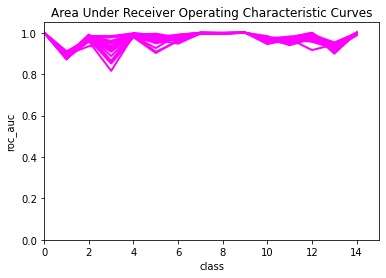

{20: [1.0, 0.8892823548940407, 0.9622356495468277, 0.950885208452313, 0.9824175824175824, 0.9259205036234536, 0.9902443609022556, 0.9998095479939055, 0.9972826086956521, 1.0, 0.9694991314418065, 0.9618589013756245, 0.9584844316618732, 0.9246759866025921, 0.9863945578231292]}


In [299]:
roc_auc_to_plot = dict()
roc_auc_to_plot = cross_validate(recipe_df, 'cuisine_SP', 21)
print(roc_auc_to_plot)

In [142]:
CV_confusion_results

array([[0.01019768, 0.1511241 , 0.0804527 , ..., 0.00784872, 0.06999556,
        0.00604796],
       [0.01009462, 0.17742597, 0.07715209, ..., 0.01302204, 0.09463825,
        0.00708836],
       [0.00281226, 0.32533395, 0.05390438, ..., 0.01597318, 0.18181164,
        0.00499601],
       ...,
       [0.00328212, 0.31917129, 0.0568868 , ..., 0.0160984 , 0.17843699,
        0.00578449],
       [0.00754941, 0.22956359, 0.08819612, ..., 0.01938484, 0.1224237 ,
        0.00643095],
       [0.00531638, 0.23461597, 0.09738904, ..., 0.01416325, 0.13209438,
        0.00686116]])